# Collaborative Recommender System using TensorFlow2

Recommendations are built upon the existing ratings of other users, who have similar ratings with the user to whom we want to recommend. Matrix factorization.

__Collaborative Filtering is a technique widely used by recommender systems when you have a decent size of _user — item_ data. It makes recommendations based on the content preferences of similar users.__

Therefore, collaborative filtering is not a suitable model to deal with [cold start](https://en.wikipedia.org/wiki/Cold_start_(computing)) problem, in which it cannot draw any inference for users or items about which it has not yet gathered sufficient information.

But once you have relative large user — item interaction data, then collaborative filtering is the most widely used recommendation approach.


[Refer](https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-with-tensorflow-82e63d27b420)

### Book-Crossing Dataset: Institut für Informatik Universität Freiburg

The data pre-processing steps are as follows:

1. Merge user, rating and book data.
1. Remove unused columns.
1. Filtering books that have had at least 25 ratings.
1. Filtering users that have given at least 20 ratings → Remember, collaborative filtering algorithms often require users’ active participation.
    
[dataset reference](http://www2.informatik.uni-freiburg.de/~cziegler/BX/)

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import tensorflow
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, InputLayer

In [2]:
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.5.0


In [3]:
gpu = tf.config.list_physical_devices('GPU')

if len(gpu) == 0:
    print("No GPU available")
else:
    print(f"number of available GPU(s) = {len(gpu)}") 

number of available GPU(s) = 1


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp /content/drive/MyDrive/BX-Book-Ratings.csv /content
!cp /content/drive/MyDrive/BX-Books.csv /content
!cp /content/drive/MyDrive/BX-Users.csv /content

In [7]:
# Read different CSV files-
rating_data = pd.read_csv("BX-Book-Ratings.csv", sep = ';', error_bad_lines = False, encoding = 'latin-1')
user_data = pd.read_csv("BX-Users.csv", sep = ';', error_bad_lines = False, encoding = 'latin-1')
book_data = pd.read_csv("BX-Books.csv", sep = ';', error_bad_lines = False, encoding = 'latin-1')

b'Skipping line 6452: expected 8 fields, saw 9\nSkipping line 43667: expected 8 fields, saw 10\nSkipping line 51751: expected 8 fields, saw 9\n'
b'Skipping line 92038: expected 8 fields, saw 9\nSkipping line 104319: expected 8 fields, saw 9\nSkipping line 121768: expected 8 fields, saw 9\n'
b'Skipping line 144058: expected 8 fields, saw 9\nSkipping line 150789: expected 8 fields, saw 9\nSkipping line 157128: expected 8 fields, saw 9\nSkipping line 180189: expected 8 fields, saw 9\nSkipping line 185738: expected 8 fields, saw 9\n'
b'Skipping line 209388: expected 8 fields, saw 9\nSkipping line 220626: expected 8 fields, saw 9\nSkipping line 227933: expected 8 fields, saw 11\nSkipping line 228957: expected 8 fields, saw 10\nSkipping line 245933: expected 8 fields, saw 9\nSkipping line 251296: expected 8 fields, saw 9\nSkipping line 259941: expected 8 fields, saw 9\nSkipping line 261529: expected 8 fields, saw 9\n'
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:27

In [8]:
rating_data.columns

Index(['User-ID', 'ISBN', 'Book-Rating'], dtype='object')

In [9]:
user_data.columns

Index(['User-ID', 'Location', 'Age'], dtype='object')

In [10]:
book_data.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication', 'Publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L'],
      dtype='object')

In [11]:
book_rating_data = pd.merge(rating_data, book_data, on = 'ISBN')

In [12]:
book_rating_data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title', 'Book-Author',
       'Year-Of-Publication', 'Publisher', 'Image-URL-S', 'Image-URL-M',
       'Image-URL-L'],
      dtype='object')

In [13]:
# Features/columns to be removed-
remove_features = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']

In [14]:
book_rating_data.drop(columns = remove_features, axis = 1, inplace = True)

In [15]:
book_rating_data.shape

(1031136, 4)

In [16]:
book_rating_data.isna().values.any()

False

In [17]:
book_rating_data.columns

Index(['User-ID', 'ISBN', 'Book-Rating', 'Book-Title'], dtype='object')

In [18]:
# Group data-
rating_count = (book_rating_data.groupby(
    by = ['Book-Title'])['Book-Rating'].
                count().
                reset_index().
                rename(columns = {'Book-Rating': 'RatingCount_book'})
                [['Book-Title', 'RatingCount_book']]
               )

In [19]:
rating_count.head()

,Book-Title,RatingCount_book
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


In [20]:
book_rating_data.groupby(by = 'Book-Title').count().reset_index().rename(columns = {'Book-Rating': 'RatingCount_book'})

,Book-Title,User-ID,ISBN,RatingCount_book
0,A Light in the Storm: The Civil War Diary of ...,4,4,4
1,Always Have Popsicles,1,1,1
2,Apple Magic (The Collector's series),1,1,1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1,1,1
4,Beyond IBM: Leadership Marketing and Finance ...,1,1,1
...,...,...,...,...
241066,Ã?Â?lpiraten.,2,2,2
241067,Ã?Â?rger mit Produkt X. Roman.,4,4,4
241068,Ã?Â?sterlich leben.,1,1,1
241069,Ã?Â?stlich der Berge.,3,3,3


In [21]:
book_rating_data.groupby(by = 'Book-Title')['Book-Rating'].count().reset_index().rename(columns = {'Book-Rating': 'RatingCount_book'})

,Book-Title,RatingCount_book
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1
...,...,...
241066,Ã?Â?lpiraten.,2
241067,Ã?Â?rger mit Produkt X. Roman.,4
241068,Ã?Â?sterlich leben.,1
241069,Ã?Â?stlich der Berge.,3


In [22]:
threshold = 25
rating_count = rating_count.query('RatingCount_book >= @threshold')
# OR-
# rating_count = rating_count[rating_count['RatingCount_book'] >= threshold]

In [23]:
rating_count.head()

,Book-Title,RatingCount_book
75,'Salem's Lot,47
203,10 Lb. Penalty,61
422,101 Dalmatians,37
673,"14,000 Things to Be Happy About",28
697,16 Lighthouse Road,65


In [24]:
user_rating = pd.merge(rating_count, book_rating_data, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')

In [25]:
user_rating.head()

,Book-Title,RatingCount_book,User-ID,ISBN,Book-Rating
0,'Salem's Lot,47,8936,067103975X,0
1,'Salem's Lot,47,172245,067103975X,0
2,'Salem's Lot,47,189835,067103975X,5
3,'Salem's Lot,47,9226,0451168089,0
4,'Salem's Lot,47,33283,0451168089,10


In [26]:
user_count = (user_rating.
     groupby(by = ['User-ID'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'RatingCount_user'})
     [['User-ID', 'RatingCount_user']]
    )

In [27]:
user_count.head()

,User-ID,RatingCount_user
0,8,2
1,9,2
2,10,1
3,14,1
4,16,2


In [28]:
threshold = 20
# user_count = user_count.query('RatingCount_user >= @threshold')
user_count = user_count[user_count['RatingCount_user'] >= threshold]

In [29]:
user_count.head()

,User-ID,RatingCount_user
52,243,68
54,254,139
89,487,21
96,507,61
115,638,51


In [30]:
combined_data = user_rating.merge(user_count, left_on = 'User-ID', right_on = 'User-ID', how = 'inner')

In [31]:
combined_data.head()

,Book-Title,RatingCount_book,User-ID,ISBN,Book-Rating,RatingCount_user
0,'Salem's Lot,47,8936,067103975X,0,177
1,1st to Die: A Novel,509,8936,0446610038,0,177
2,A Case of Need,236,8936,0451210638,0,177
3,A Perfect Stranger,54,8936,0440168724,0,177
4,Accident,126,8936,0440217547,0,177


In [32]:
print(f"combined_data dimensions/shape = {combined_data.shape}")

combined_data dimensions/shape = (263467, 6)


In [33]:
print(f"Number of unique users = {combined_data['User-ID'].nunique()} and number of unique books = {combined_data['Book-Title'].nunique()}")

Number of unique users = 3192 and number of unique books = 5850


- Our final dataset ```combined_data``` contains 3,192 users for 5,850 books.
- Each user has given at least 20 ratings and each book has received at least 25 ratings.

The collaborative filtering approach focuses on finding users who have given similar ratings to the same books, thus creating a link between users, to whom books will be suggested that were reviewed in a positive way. Hence, __we look for associations between users and not between books__. __Therefore, collaborative filtering relies only on observed user behavior to make recommendations — no profile data or content data is necessary.__


Our technique will be based on the following observations:

- Users who rate books in a similar manner share one or more hidden preferences.
- Users with shared preferences are likely to give ratings in the same way to the same books.

In [34]:
combined_data['Book-Rating'] = combined_data['Book-Rating'].values.astype(float)

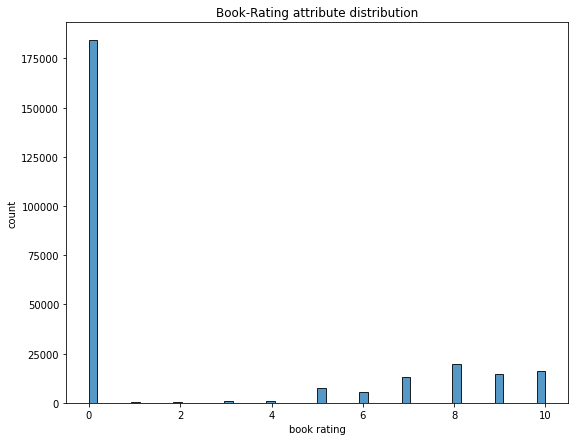

In [35]:
# Visualize distribution of 'Book-Rating' attribute-
# plt.figure(figsize = (9, 7))
# plt.hist(combined_data['Book-Rating'])

fig_dims = (9, 7)
fig, ax = plt.subplots(figsize = fig_dims)
sns.histplot(data = combined_data, x = 'Book-Rating', ax = ax)
plt.title("Book-Rating attribute distribution")
plt.xlabel("book rating")
plt.ylabel("count")
plt.show()


In [36]:
# Scale values-
scaler_mm = MinMaxScaler()
book_rating_scaled = scaler_mm.fit_transform(combined_data['Book-Rating'].values.reshape(-1, 1))
combined_data['Book-Rating'] = book_rating_scaled

In [37]:
# Sanity check-
combined_data['Book-Rating'].min(), combined_data['Book-Rating'].max()

(0.0, 1.0)

In [38]:
# Construct user and book matrices using 3 features/columns-

# Drop duplicates in these 2 columns-
combined_data = combined_data.drop_duplicates(['User-ID', 'Book-Title'])

user_book_matrix = combined_data.pivot(index = 'User-ID', columns = 'Book-Title', values = 'Book-Rating')
user_book_matrix.fillna(0, inplace = True)

In [39]:
user_book_matrix.shape

(3192, 5850)

In [40]:
users = user_book_matrix.index.tolist()
books = user_book_matrix.columns.tolist()

user_book_matrix = user_book_matrix.values

In [41]:
num_input = combined_data['Book-Title'].nunique()
num_hidden_1 = 10
num_hidden_2 = 5

In [42]:
num_input

5850

In [43]:
X = tf.random.normal(shape = (1, num_input))

In [44]:
X.shape

TensorShape([1, 5850])

In [45]:
class Autoencoder(Model):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = Sequential([
            InputLayer(input_shape = (num_input, )),
            Dense(
                units = 2925, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 1200, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 600, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 300, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 150, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 70, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 30, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 15, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
        ])
        
        self.decoder = Sequential([
            Dense(
                units = 30, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 70, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 150, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 300, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 600, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 1200, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = 2925, activation = 'relu',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            ),
            Dense(
                units = num_input, activation = 'sigmoid',
                kernel_initializer = tf.keras.initializers.glorot_normal()
            )
        ]
        )
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [55]:
# Instantiate an instance of defined autoencoder-
model = Autoencoder()

In [47]:
encoded_X = model.encoder(X)

In [48]:
encoded_X.shape

TensorShape([1, 15])

In [49]:
# Prediction and/or reconstructed output from Autoencoder-
decoded_X = model.decoder(encoded_X)

In [50]:
decoded_X.shape, X.shape

(TensorShape([1, 5850]), TensorShape([1, 5850]))

In [56]:
# Compile Autoencoder-
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
)

In [57]:
# Define early stopping criterion-
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss', min_delta = 0.001,
    patience = 3, restore_best_weights = True
)

In [58]:
# Train autoencoder-
history = model.fit(
    x = user_book_matrix, y = user_book_matrix,
    batch_size = 32, epochs = 10,
    callbacks = [early_stopping] 
)

Epoch 1/10
100/100 [==============================] - 2s 14ms/step - loss: 0.0295
Epoch 2/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 3/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 4/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 5/10
100/100 [==============================] - 1s 14ms/step - loss: 0.0027


In [59]:
# Get summary of defined autoencoder-
model.summary()

Model: "autoencoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 15)                21584590  
_________________________________________________________________
sequential_3 (Sequential)    (None, 5850)              21590425  
Total params: 43,175,015
Trainable params: 43,175,015
Non-trainable params: 0
_________________________________________________________________


In [60]:
tot_params = 0

for layer in model.trainable_weights:
    loc_param = tf.math.count_nonzero(layer, axis = None).numpy()
    tot_params += loc_param
    print(f"layer.shape: {layer.shape} has {loc_param} weights")

layer.shape: (5850, 2925) has 17111248 weights
layer.shape: (2925,) has 2925 weights
layer.shape: (2925, 1200) has 3510000 weights
layer.shape: (1200,) has 1200 weights
layer.shape: (1200, 600) has 720000 weights
layer.shape: (600,) has 600 weights
layer.shape: (600, 300) has 180000 weights
layer.shape: (300,) has 295 weights
layer.shape: (300, 150) has 45000 weights
layer.shape: (150,) has 144 weights
layer.shape: (150, 70) has 10500 weights
layer.shape: (70,) has 62 weights
layer.shape: (70, 30) has 2100 weights
layer.shape: (30,) has 22 weights
layer.shape: (30, 15) has 450 weights
layer.shape: (15,) has 13 weights
layer.shape: (15, 30) has 450 weights
layer.shape: (30,) has 24 weights
layer.shape: (30, 70) has 2100 weights
layer.shape: (70,) has 53 weights
layer.shape: (70, 150) has 10500 weights
layer.shape: (150,) has 122 weights
layer.shape: (150, 300) has 45000 weights
layer.shape: (300,) has 234 weights
layer.shape: (300, 600) has 180000 weights
layer.shape: (600,) has 475 wei

In [61]:
print(f"Total number of trainable parameters = {tot_params}")

Total number of trainable parameters = 43173902


In [62]:
pred_data = pd.DataFrame()

In [63]:
batch_size = 32

In [64]:
num_batches = int(user_book_matrix.shape[0] / batch_size)    

In [65]:
num_batches

99

In [66]:
user_book_matrix.shape

(3192, 5850)

In [67]:
# Split into batches-
user_book_matrix_split = np.array_split(user_book_matrix, num_batches)

In [70]:
len(user_book_matrix_split), type(user_book_matrix_split)

(99, list)

In [72]:
# Sanity check-

i = 0
for batch in user_book_matrix_split:
    if i >= 5:
        break
        
    print(batch.shape)
    i += 1


(33, 5850)
(33, 5850)
(33, 5850)
(33, 5850)
(33, 5850)


In [73]:
user_book_matrix_concat = np.concatenate(user_book_matrix_split, axis=0)

In [74]:
user_book_matrix_concat.shape, user_book_matrix.shape

((3192, 5850), (3192, 5850))

In [76]:
predictions = model(user_book_matrix)

In [77]:
predictions.shape

TensorShape([3192, 5850])

In [ ]:
pred_data = pred_data.append(pd.DataFrame(predictions))

In [ ]:
pred_data.shape

In [ ]:
pred_data = pred_data.stack().reset_index(name = 'Book-Rating')
pred_data.columns = ['User-ID', 'Book-Title', 'Book-Rating']
pred_data['User-ID'] = pred_data['User-ID'].map(lambda value: users[value])
pred_data['Book-Title'] = pred_data['Book-Title'].map(lambda value: books[value])

In [ ]:
keys = ['User-ID', 'Book-Title']
index_1 = pred_data.set_index(keys).index
index_2 = combined.set_index(keys).index

top_ten_ranked = pred_data[~index_1.isin(index_2)]
top_ten_ranked = top_ten_ranked.sort_values(['User-ID', 'Book-Rating'], ascending=[True, False])
top_ten_ranked = top_ten_ranked.groupby('User-ID').head(10)

In [ ]:
# Get book recommendations for a randomly selected user.
# top 10 results for this user, sorted by the normalized predicted ratings-
top_ten_ranked.loc[top_ten_ranked['User-ID'] == 278582]

In [ ]:
# Get books he (or she) has rated, sorted by ratings-
book_rating.loc[book_rating['User-ID'] == 278582].sort_values(
    by = ['Book-Rating'],
    ascending = False)
